In [1]:
cd ..

/home/martinsevilla/langevin_ggm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
# from ggm_estimation.utils import _lambda_generic, lambda_glasso_selector
from ggm_estimation.format_results import plot_glasso_tuning

np.set_printoptions(suppress=True)

plt.rcParams['figure.figsize'] = [6, 5]

mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

%load_ext autoreload
%autoreload 2

#### Tuning

In [3]:
graph_type = "deezer"
nans = 1.0
one_zero_ratio = None
n_proportional = True
metric = "f1"

# graph_type = "barabasi"
# nans = 30
# one_zero_ratio = 0.5
# n_proportional = False
# metric = "accuracy"

# graph_type = "deezer"
# nans = 0.5
# one_zero_ratio = None
# n_proportional = True
# metric = "f1"

# graph_type = "grids"
# graph_type = "barabasi"
# nans = 0.1
# one_zero_ratio = 0.2
# n_proportional = True
# metric = "f1"

# graph_type = "grids"
# nans = 1.0
# one_zero_ratio = None
# n_proportional = True
# metric = "f1"

filename = f"outputs/tuning/tuning_glasso_{graph_type}_{nans}_{n_proportional}_{one_zero_ratio}_{metric}.csv"

[  3.16160777 -17.52335464  45.6692579 ]


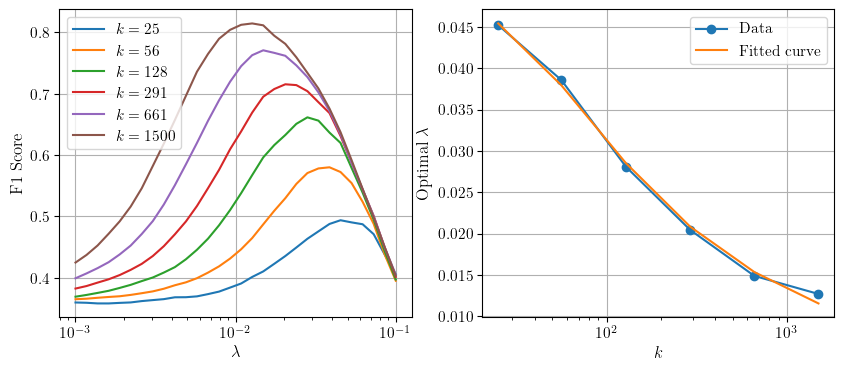

In [4]:
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels

plot_glasso_tuning(filename, metric="F1 Score", output_file=None, 
                   legend_ncol=1, legend_loc="upper left")